In [1]:
#导入包
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)


#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

from matplotlib.colors import LinearSegmentedColormap
sc_color=['#7CBB5F','#368650','#A499CC','#5E4D9A','#78C2ED','#866017', '#9F987F','#E0DFED',
 '#EF7B77', '#279AD7','#F0EEF0', '#1F577B', '#A56BA7', '#E0A7C8', '#E069A6', '#941456', '#FCBC10',
 '#EAEFC5', '#01A0A7', '#75C8CC', '#F0D7BC', '#D5B26C', '#D5DA48', '#B6B812', '#9DC3C3', '#A89C92', '#FEE00C', '#FEF2A1']
sc_color_cmap = LinearSegmentedColormap.from_list('Custom', sc_color, len(sc_color))

anndata(Ver):  0.8.0
scanpy(Ver):  1.9.1
matplotlib(Ver):  3.5.1
seaborn(Ver):  0.11.2
numpy(Ver):  1.22.3
pandas(Ver):  1.3.5
scvelo(Ver):  0.2.4
Pyomic(Ver):  1.1.4


In [2]:
from sklearn import preprocessing

In [4]:
rna=sc.read('data/rna_anno_new.h5ad')

#rna=rna.raw.to_adata()
atac=sc.read('data/atac_anno_new.h5ad')
#rna,atac

In [3]:
rna.obs['SRR'].unique()

['SRR13633759', 'SRR13633760', 'SRR13633761', 'SRR13633762']
Categories (4, object): ['SRR13633759', 'SRR13633760', 'SRR13633761', 'SRR13633762']

In [5]:
atac.obs['SRR'].unique()

['SRR13633766', 'SRR13633772']
Categories (2, object): ['SRR13633766', 'SRR13633772']

In [4]:
#读取数据
#提取GLUE层结果
rna_loc=pd.DataFrame(rna.obsm['X_glue'], index=rna.obs.index)
atac_loc=pd.DataFrame(atac.obsm['X_glue'], index=atac.obs.index)

#对GLUE层进行Pearson系数分析
import numpy as np
import gc
len1=(len(rna_loc)//5000)+1
p_pd=pd.DataFrame(columns=['rank_'+str(i) for i in range(50)])
n_pd=pd.DataFrame(columns=['rank_'+str(i) for i in range(50)])
for j in range(len1):
    c=pd.DataFrame()
    for i in range(len1):
        t1=rna_loc.iloc[5000*(i):5000*(i+1)]
        t2=atac_loc.iloc[5000*(j):5000*(j+1)]
        a=np.corrcoef(t1,t2)[len(t1):,0:len(t1)]
        b=pd.DataFrame(a,index=t2.index,columns=t1.index)  

        c=pd.concat([c,b],axis=1)
        del t1
        del t2
        del a
        del b
        gc.collect()
    for i in range(len(c)):
        t_c=c.iloc[i]
        p_pd.loc[t_c.name]=c.iloc[i].sort_values(ascending=False)[:50].values
        n_pd.loc[t_c.name]=c.iloc[i].sort_values(ascending=False)[:50].index.tolist()
    print('Now epoch is {}, {}/{}'.format(j,j*5000+len(c),len(atac_loc))) 
    del c
    gc.collect()

#寻找最近的细胞，其中depth的灵活调整可以使得配对成功的细胞数变大，同时精度有所下降
def find_neighbor_cell(p_pd,n_pd,depth=10):
    rubish_c=[]
    finish_c=[]
    for d in range(depth):
        p_pd=p_pd.loc[p_pd['rank_{}'.format(d)]>0.9]
        p_pd=p_pd.sort_values('rank_{}'.format(d),ascending=False)
        for i in p_pd.index:
            name=n_pd.loc[i,'rank_{}'.format(d)]
            if name not in rubish_c:
                finish_c.append(i)
                rubish_c.append(name)
            else:
                continue
        p_pd=p_pd.loc[~p_pd.index.isin(finish_c)]
        n_pd=n_pd.loc[~n_pd.index.isin(finish_c)]
    result=pd.DataFrame()
    result['omic_1']=rubish_c
    result['omic_2']=finish_c
    result.index=['cell_{}'.format(i) for i in range(len(result))]
    return result

res_pair=find_neighbor_cell(p_pd,n_pd,depth=20)
res_pair.head()


Now epoch is 0, 5000/21194
Now epoch is 1, 10000/21194
Now epoch is 2, 15000/21194
Now epoch is 3, 20000/21194
Now epoch is 4, 21194/21194


,omic_1,omic_2
cell_0,TGTGTGAAGAGGTCAC-SRR13633761,CCCTGATGTAAAGCTA-1-772
cell_1,ACTACGATCTCCAAGA-SRR13633761,TTCGATTGTCGTAATC-1-772
cell_2,GACTGATAGACAGCTG-SRR13633761,AGCGTATGTCTCAAAC-1-772
cell_3,ATGGATCAGCGATGAC-SRR13633761,AGCTGGCTCCCAATGA-1-772
cell_4,AGTCTCCGTCGAACAG-SRR13633761,CACATGATCGTCGCAG-1-772


In [5]:
res_pair.to_csv('res_pair_glue.csv')

<AxesSubplot:title={'center':'scATAC-seq'}, xlabel='X_umap1', ylabel='X_umap2'>

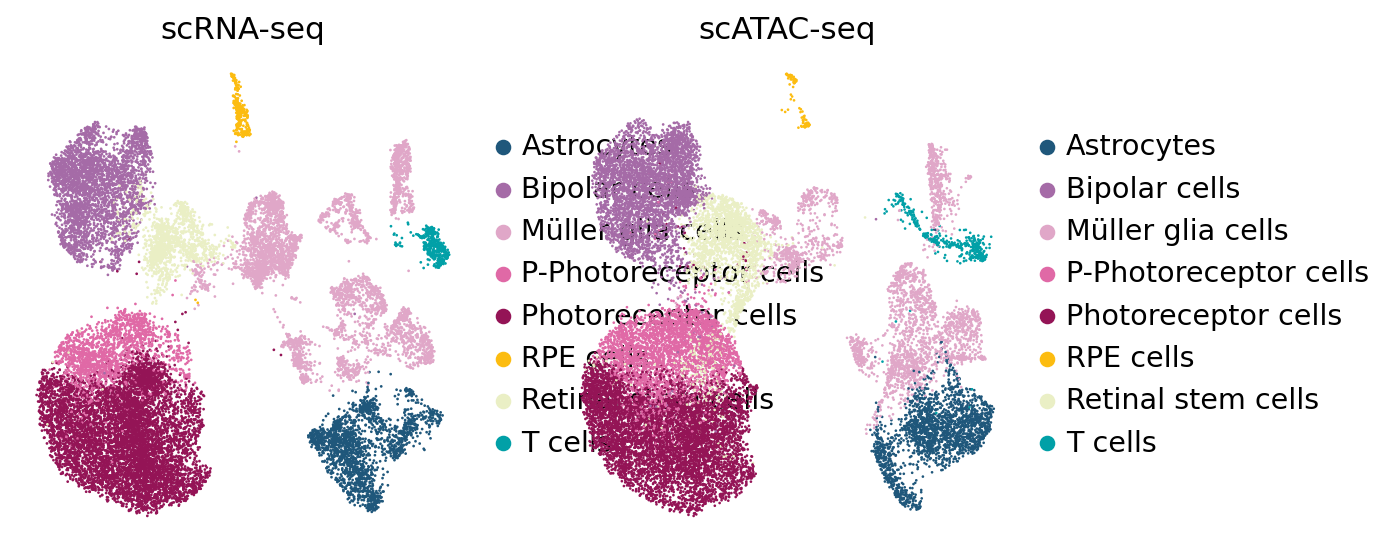

In [11]:
fig, axes = plt.subplots(1,2,figsize=(8,4))

sc.pl.embedding(
    rna,
    basis="X_umap",
    color=['major_celltype_new'],
    title='scRNA-seq',
    frameon=False,
    ncols=1,
    #save='_figure1_celltype.png',
    #return_fig=True,
    #wspace=0.5,
    show=False,
    ax=axes[0]
    #palette=sc_color[11:],
)

sc.pl.embedding(
    atac,
    basis="X_umap",
    color=['major_celltype_new'],
    title='scATAC-seq',
    frameon=False,
    ncols=1,
    #save='_figure1_celltype.png',
    #return_fig=True,
    #wspace=0.5,
    show=False,
    ax=axes[1]
    #palette=sc_color[11:],
)


In [12]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Photoreceptor cells',
     '1': 'Photoreceptor cells',
     '2': 'Müller glia cells',#Germ-cell(Oid)
     '3': 'Photoreceptor cells',#Germ-cell(Oid)
     '4': 'STER cells',
     '5': 'Astrocytes',
     '6': 'Retinal stem cells',
     '7': 'Photoreceptor progenitor cell',
     '8': 'STER cells',
     '9': 'Photoreceptor cells',
     '10': 'Astrocytes',#Germ-cell(Oid)
     '11': 'Photoreceptor progenitor cell',
     '12': 'Müller glia cells',
     '13': 'Müller glia cells',
     '14': 'Müller glia cells',
     '15': 'STER cells',#Germ
     '16': 'Photoreceptor cells',#plasma
     '17': 'Lymphocytes',#plasma
     '18': 'Müller glia cells',
     '19': 'Müller glia cells',
     '20': 'Retinal pigment epithelium (RPE) cells',#Germ-cell(Oid)
     '21': 'STER cells',
     '22': 'Müller glia cells',
     '23': 'Müller glia cells',



}
rna.obs['major_celltype'] = rna.obs['leiden'].map(cluster2annotation).astype('category')

In [13]:
#这里纯人眼识别，其实可以开发一个算法的
cluster2annotation = {
     '0': 'Photoreceptor cells',
     '1': 'Photoreceptor cells',
     '2': 'Photoreceptor progenitor cell',#Germ-cell(Oid)
     '3': 'Retinal stem cells',#Germ-cell(Oid)
     '4': 'Astrocytes',
     '5': 'STER cells',
     '6': 'STER cells',
     '7': 'Müller glia cells',
     '8': 'Photoreceptor cells',
     '9': 'STER cells',
     '10': 'Photoreceptor progenitor cell',#Germ-cell(Oid)
     '11': 'Müller glia cells',
     '12': 'Retinal stem cells',
     '13': 'Müller glia cells',
     '14': 'Müller glia cells',
     '15': 'Astrocytes',#Germ
     '16': 'Lymphocytes',#plasma
     '17': 'Photoreceptor progenitor cell',#plasma
     '18': 'Müller glia cells',
     '19': 'Müller glia cells',
     '20': 'Retinal pigment epithelium (RPE) cells',#Germ-cell(Oid)



}
atac.obs['major_celltype'] = atac.obs['leiden'].map(cluster2annotation).astype('category')

In [14]:
rna.obs['major_celltype_new']=rna.obs['major_celltype']
rna.obs['major_celltype_new']=rna.obs['major_celltype_new'].astype('str')
rna.obs.loc[rna.obs['major_celltype']=='Retinal pigment epithelium (RPE) cells','major_celltype_new']='RPE cells'
rna.obs.loc[rna.obs['major_celltype']=='Retinal progenitor cells (RPCs)','major_celltype_new']='RPCs'
rna.obs.loc[rna.obs['major_celltype']=='Photoreceptor progenitor cell','major_celltype_new']='P-Photoreceptor cells'
rna.obs['major_celltype_new']=rna.obs['major_celltype_new'].astype('category')

In [15]:
atac.obs['major_celltype_new']=atac.obs['major_celltype']
atac.obs['major_celltype_new']=atac.obs['major_celltype_new'].astype('str')
atac.obs.loc[atac.obs['major_celltype']=='Retinal pigment epithelium (RPE) cells','major_celltype_new']='RPE cells'
atac.obs.loc[atac.obs['major_celltype']=='Retinal progenitor cells (RPCs)','major_celltype_new']='RPCs'
atac.obs.loc[atac.obs['major_celltype']=='Photoreceptor progenitor cell','major_celltype_new']='P-Photoreceptor cells'
atac.obs['major_celltype_new']=atac.obs['major_celltype_new'].astype('category')

In [16]:
motif_adata=sc.read('data/motif_anno.h5ad')
act=sc.read('data/act_anno_new.h5ad')

In [17]:
motif_adata.obs=atac.obs.loc[motif_adata.obs.index]
motif_adata.obsp=atac[motif_adata.obs.index].obsp
motif_adata.obsm=atac[motif_adata.obs.index].obsm
motif_adata.uns=atac[motif_adata.obs.index].uns
motif_adata

AnnData object with n_obs × n_vars = 21194 × 733
    obs: 'Tissue', 'Developmental_Stage', 'SRR', 'nb_features', 'log_nb_features', 'domain', 'balancing_weight', 'leiden', 'major_celltype', 'major_celltype_new'
    uns: 'Developmental_Stage_colors', 'SRR_colors', '__scglue__', 'leiden', 'leiden_colors', 'major_celltype_colors', 'major_celltype_new_colors', 'neighbors', 'umap'
    obsm: 'X_glue', 'X_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [18]:
act.obs=atac.obs.loc[act.obs.index]
act.obsp=atac[act.obs.index].obsp
act.obsm=atac[act.obs.index].obsm
act.uns=atac[act.obs.index].uns

In [19]:
act

AnnData object with n_obs × n_vars = 21194 × 59454
    obs: 'Tissue', 'Developmental_Stage', 'SRR', 'nb_features', 'log_nb_features', 'domain', 'balancing_weight', 'leiden', 'major_celltype', 'major_celltype_new'
    uns: 'Developmental_Stage_colors', 'SRR_colors', '__scglue__', 'leiden', 'leiden_colors', 'major_celltype_colors', 'major_celltype_new_colors', 'neighbors', 'umap'
    obsm: 'X_glue', 'X_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [22]:
#sc.pp.normalize_total(act)
sc.pp.scale(act, max_value=10)
sc.pp.highly_variable_genes(act, min_mean=0.0125, max_mean=3, min_disp=0.5)
act = act[:, act.var.highly_variable]
act

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
extracting highly variable genes
    finished (0:00:12)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


View of AnnData object with n_obs × n_vars = 21194 × 2990
    obs: 'Tissue', 'Developmental_Stage', 'SRR', 'nb_features', 'log_nb_features', 'domain', 'balancing_weight', 'leiden', 'major_celltype', 'major_celltype_new'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Developmental_Stage_colors', 'SRR_colors', '__scglue__', 'leiden', 'leiden_colors', 'major_celltype_colors', 'major_celltype_new_colors', 'neighbors', 'umap', 'hvg'
    obsm: 'X_glue', 'X_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

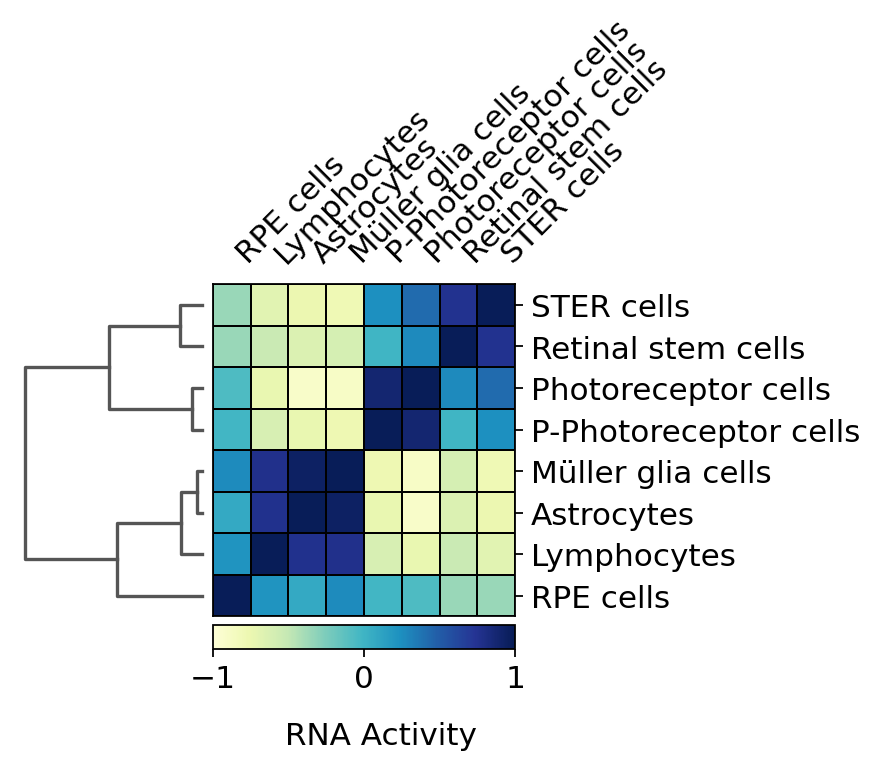

In [61]:
sc.pl.correlation_matrix(act, 'major_celltype_new', 
                         figsize=(4,3),
                         cmap='YlGnBu',
                         dendrogram=True,
                         show=False,
                         )
plt.suptitle('RNA Activity',fontsize=14,x=0.75,y=0,horizontalalignment='center')
plt.savefig('result_1/act_correlation.png',dpi=300,bbox_inches='tight')

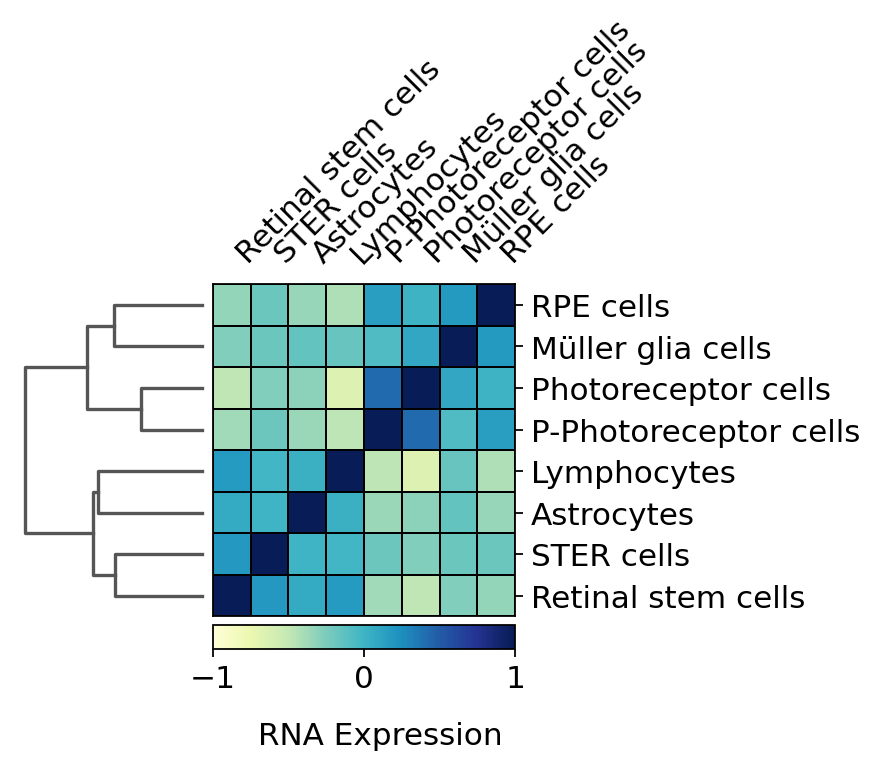

In [60]:
sc.pl.correlation_matrix(rna, 'major_celltype_new', 
                         figsize=(4,3),
                         cmap='YlGnBu',
                         dendrogram=True,
                         show=False,
                         )
plt.suptitle('RNA Expression',fontsize=14,x=0.75,y=0,horizontalalignment='center')
plt.savefig('result_1/scRNA_correlation.png',dpi=300,bbox_inches='tight')

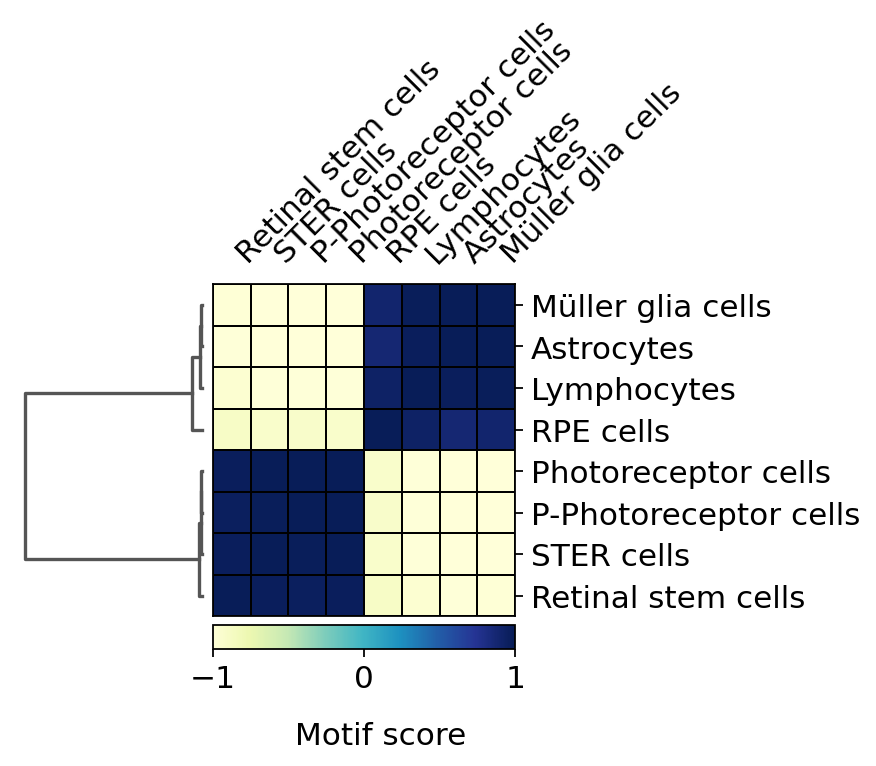

In [59]:
sc.pl.correlation_matrix(motif_adata, 'major_celltype_new', 
                         figsize=(4,3),
                         cmap='YlGnBu',
                         dendrogram=True,
                         show=False,
                         #font={'size':12}
                         )
plt.suptitle('Motif score',fontsize=14,x=0.75,y=0,horizontalalignment='center')
plt.savefig('result_1/motif_correlation.png',dpi=300,bbox_inches='tight')

<AxesSubplot:title={'center':'scRNA-seq'}, xlabel='X_umap1', ylabel='X_umap2'>

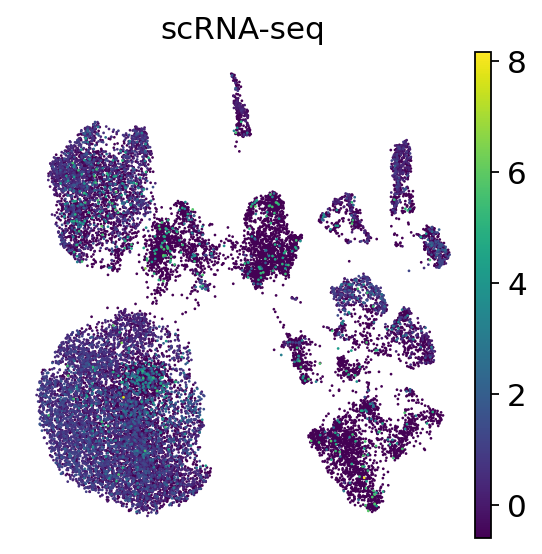

In [87]:

sc.pl.embedding(
    rna,
    basis="X_umap",
    color=['PANK2'],
    title='scRNA-seq',
    frameon=False,
    ncols=4,
    #save='_figure1_celltype.png',
    #return_fig=True,
    #wspace=0.5,
    show=False,
    #ax=axes[0]
    #palette=sc_color[11:],
)

<AxesSubplot:title={'center':'chr17_60088183_60089031'}, xlabel='X_umap1', ylabel='X_umap2'>

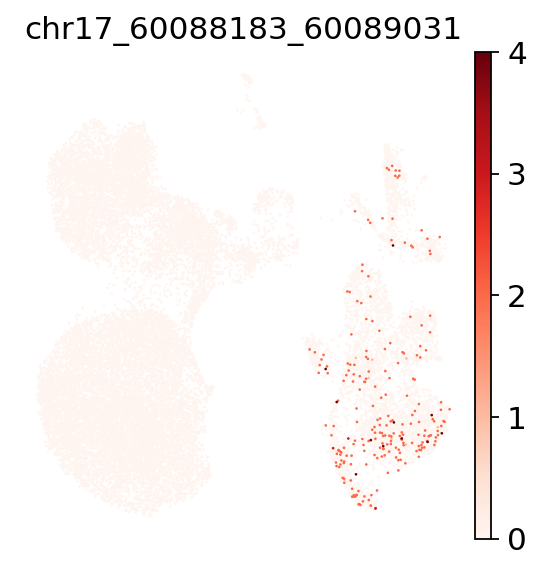

In [73]:

sc.pl.embedding(
    atac,
    basis="X_umap",
    color=['chr17_60088183_60089031'],
    #title='scRNA-seq',
    frameon=False,
    ncols=4,
    #save='_figure1_celltype.png',
    #return_fig=True,
    #wspace=0.5,
    show=False,
    cmap='Reds',
    #ax=axes[0]
    #palette=sc_color[11:],
)

In [74]:
act

AnnData object with n_obs × n_vars = 21194 × 2990
    obs: 'Tissue', 'Developmental_Stage', 'SRR', 'nb_features', 'log_nb_features', 'domain', 'balancing_weight', 'leiden', 'major_celltype', 'major_celltype_new'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Developmental_Stage_colors', 'SRR_colors', '__scglue__', 'leiden', 'leiden_colors', 'major_celltype_colors', 'major_celltype_new_colors', 'neighbors', 'umap', 'hvg', 'dendrogram_major_celltype_new'
    obsm: 'X_glue', 'X_lsi', 'X_umap', 'X_pca'
    obsp: 'connectivities', 'distances'

In [76]:
rna1=sc.read('data/rna_anno_new.h5ad')
rna1

AnnData object with n_obs × n_vars = 20037 × 2000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'SRR', 'Cancer', 'Tissue', 'Developmental_Stage', 'sample', 'Type', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'SRR1', 'balancing_weight', 'n_counts', 'major_celltype', 'major_celltype_new'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'hgnc_id', 'havana_gene', 'tag', 'dell', 'dispersions', 'dispersions_norm'
    uns: 'Cancer_colors', 'Developmental_Stage_color

In [77]:
ret_gene=list(set(act.var.index) & set(rna1.var.index))
len(ret_gene)

126

In [78]:
res_pair=pd.read_csv('res_pair_glue.csv')

In [79]:
def adata_rename(adata,pair,omic_name='omic_1'):
    adata=adata[pair[omic_name].values]
    adata.obs.index=pair.index
    return adata

In [80]:
rna1=adata_rename(rna1,res_pair,omic_name='omic_1')
atac1=adata_rename(atac,res_pair,omic_name='omic_2')
rna1,atac1

(View of AnnData object with n_obs × n_vars = 12361 × 2000
     obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'SRR', 'Cancer', 'Tissue', 'Developmental_Stage', 'sample', 'Type', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'SRR1', 'balancing_weight', 'n_counts', 'major_celltype', 'major_celltype_new'
     var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'hgnc_id', 'havana_gene', 'tag', 'dell', 'dispersions', 'dispersions_norm'
     uns: 'Cancer_colors', 'Developmental

In [84]:
act1=act[atac1.obs.index]
act1

View of AnnData object with n_obs × n_vars = 12361 × 2990
    obs: 'Tissue', 'Developmental_Stage', 'SRR', 'nb_features', 'log_nb_features', 'domain', 'balancing_weight', 'leiden', 'major_celltype', 'major_celltype_new'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Developmental_Stage_colors', 'SRR_colors', '__scglue__', 'leiden', 'leiden_colors', 'major_celltype_colors', 'major_celltype_new_colors', 'neighbors', 'umap', 'hvg', 'dendrogram_major_celltype_new'
    obsm: 'X_glue', 'X_lsi', 'X_umap', 'X_pca'
    obsp: 'connectivities', 'distances'

In [ ]:
from scipy import stats
gene2peak_cor=[]
res_gene2act=pd.DataFrame()
for i in ret_gene:
    cor1=stats.spearmanr(act1[:,i].X.toarray().T[0],
            rna1[:,i].X.toarray().T[0])[0]
    gene2peak_cor.append(cor1)
res_gene2act['gene']=ret_gene
res_gene2act['cor']=gene2peak_cor
res_gene2act

In [86]:
import gc
gc.collect()

9468